# **Детекция объектов**



## Данные

Скачиваем датасет с кадрами игр в квиддич из Гарри Поттера. Хотим научиться искать и выделять на фотографиях бладжеры, квоффл и снитч. Разметка находится в xmls папке, картинки в images.

In [1]:
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

!unzip -q data.zip

--2025-01-23 16:08:06--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2025-01-23 16:08:07--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2025-01-23 16:08:08 (161 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Создание Dataset

Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)

        class_name = member.find("name").text
        class_index = class_dict[class_name]

        res = (xmin, ymin, xmax, ymax, class_index)
        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        fname = self.filenames[idx]
        image_path = str(self.root / "images" / fname.split("/")[-1])

        image = np.array(Image.open(image_path).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)


    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Визулизация

Реализуем функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(images, bboxes, class_dict_inv):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        image = images[i].permute(1, 2, 0).numpy()  # перестановка каналов для matplotlib

        # Откат нормализации
        image = (image * std) + mean

        ax.imshow(image)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_index = bbox
            class_name = class_dict_inv[class_index]

            # Создание прямоугольника
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=1, edgecolor='r', facecolor='none'
            )

            # Добавление прямоугольника к графику
            ax.add_patch(rect)

            # Добавление текста с аннотацией класса
            ax.text(
                xmin, ymin, class_name,
                bbox=dict(facecolor='red', alpha=0.5),
                fontsize=8, color='white'
            )

    fig.tight_layout()
    plt.show()


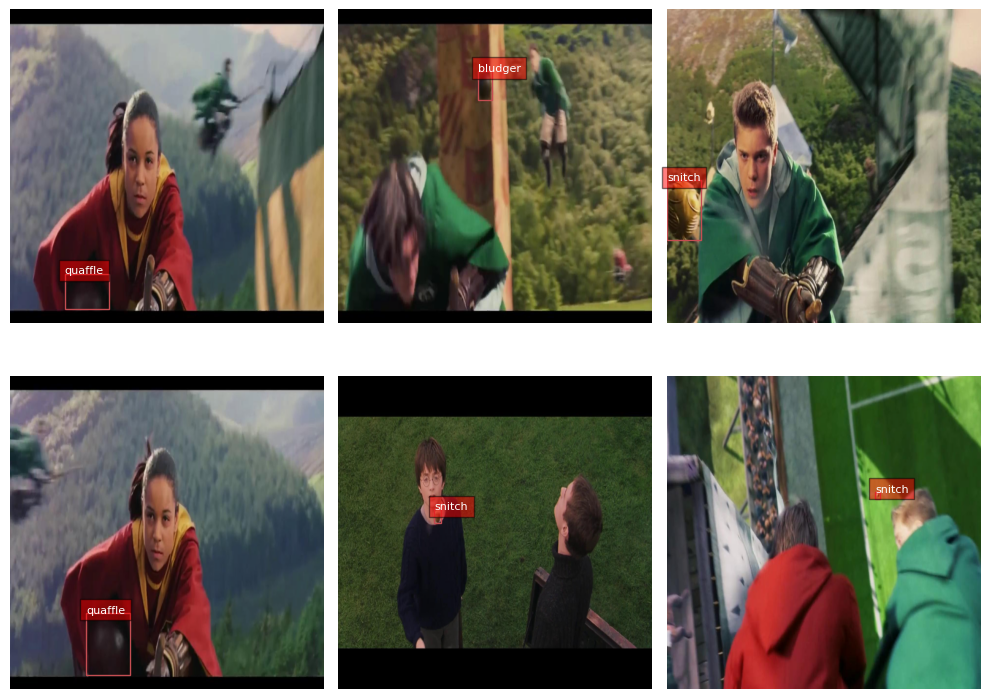

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out], train_ds.class_dict_inv)

# **YOLO-like детектор**

Реализуем детектор, похожий на YOLO, немного его упростив. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Collate function

Реализуем collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров.

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуем ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample
        y_cell =  downsample
        w_box =  (xmax-xmin) / w
        h_box =  (ymax-ymin) / h

        # Посчитаем координаты центра и сдвиги
        cx =  (xmin+xmax) / 2
        cy =  (ymin+ymax) / 2
        cx_idx =  (cx // downsample).to(torch.long) #(считаем индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx =  (cy // downsample).to(torch.long)

        cx_box =  (cx  - cx_idx*downsample) / downsample #(считаем сдивиги относительно cx_idx)
        cy_box =  (cy - cy_idx*downsample) / downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже можем увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

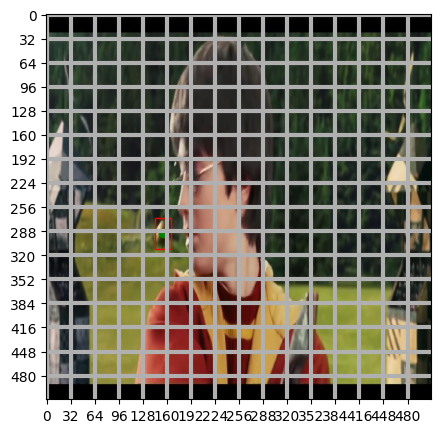

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Обратное преобразование

Реализуем обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function мы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.


In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    boxes = []

    for batch_idx in range(b):
        for y in range(h):
            for x in range(w):

                if len(pred[batch_idx, :, y, x]) == 6:
                    cx_box, cy_box, w_box, h_box, confidence, class_idx = pred[batch_idx, :, y, x]
                    confidence = confidence.item()
                    class_idx = int(class_idx.item())
                else:
                    cx_box, cy_box, w_box, h_box, confidence, p1,p2,p3 = pred[batch_idx, :, y, x]
                    confidence = confidence.item()
                    class_idx = int(torch.argmax(torch.tensor([p1, p2, p3])).item())

                if confidence > threshold:
                    cx = (x + cx_box.item()) * upsample
                    cy = (y + cy_box.item()) * upsample
                    w_box *= img_w
                    h_box *= img_h
                    xmin = int(cx - w_box / 2)
                    ymin = int(cy - h_box / 2)
                    xmax = int(cx + w_box / 2)
                    ymax = int(cy + h_box / 2)

                    boxes.append([(xmin, ymin, xmax, ymax, class_idx)])

    return boxes


## Модель


In [ ]:
class Detector(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        resnet50 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Extract layers up to layer4 (inclusive) from ResNet50
        self.resnet_layers = nn.Sequential(
            resnet50.conv1,
            resnet50.bn1,
            resnet50.relu,
            resnet50.maxpool,
            resnet50.layer1,
            resnet50.layer2,
            resnet50.layer3,
            resnet50.layer4
        )

        # Additional layers for detection
        self.extra_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + num_classes, kernel_size=3, padding=1)
        )

        # Sigmoid activation for the final layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):

        resnet_out = self.resnet_layers(img)
        extra_out = self.extra_layers(resnet_out)
        final_out = self.sigmoid(extra_out)

        return final_out



## Функция потерь

Реализуем функцию потерь.

Для этого:
* Сделаем маску, которая будет говорить о положении детектируемых объектов
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


In [ ]:
def special_loss(pred, target, check=False, C=3):

    pred_conf = pred[:, 4, :, :]
    target_conf = target[:, 4, :, :]

    mask = target_conf > 0

    localization_loss = nn.MSELoss(reduction='sum')(torch.masked_select(pred[:,0,:,:],mask), torch.masked_select(target[:,0,:,:],mask)
    ) + nn.MSELoss(reduction='sum')(torch.masked_select(pred[:,1,:,:],mask), torch.masked_select(target[:,1,:,:],mask))

    box_loss = nn.MSELoss(reduction='sum')(torch.masked_select(pred[:,2,:,:]**0.5,mask), torch.masked_select(target[:,2,:,:]**0.5,mask)
    ) + nn.MSELoss(reduction='sum')(torch.masked_select(pred[:,3,:,:]**0.5,mask), torch.masked_select(target[:,3,:,:]**0.5,mask))

    target_class = torch.masked_select(target[:,5,:,:], mask)
    pred_class_1 = torch.masked_select(pred[:,5,:,:], mask)
    pred_class_2 = torch.masked_select(pred[:,6,:,:], mask)
    pred_class_3 = torch.masked_select(pred[:,7,:,:], mask)
    pred_matrix = torch.stack([pred_class_1, pred_class_2, pred_class_3], dim=1)
    classification_loss = nn.CrossEntropyLoss(reduction='sum')(pred_matrix, target_class.long())

    loss_1 = nn.BCELoss(reduction='sum')(torch.masked_select(pred_conf, mask), torch.masked_select(target_conf, mask))
    loss_2 = 0.1*nn.BCELoss(reduction='sum')(torch.masked_select(pred_conf, ~mask).float(), torch.masked_select(target_conf, ~mask).float())
    confidence_loss = loss_1 + loss_2

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss


# Обучение

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.manual_seed(21)
EPOCHS = 20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images = batch["image"].to(device, dtype=torch.float32)
        targets = batch["target"].to(device, dtype=torch.float32)

        opt.zero_grad()

        predictions = model(images)

        loss = special_loss(predictions, targets)

        loss.backward()

        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({"Train loss": loss.item()})

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 72.276;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 27.613;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 17.572;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 14.371;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 12.856;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 10.305;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 9.929;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 9.293;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 8.945;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 8.645;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 8.563;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 8.276;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 8.022;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 7.828;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 8.572;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 8.244;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 7.454;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 7.154;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 7.121;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 6.605;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
model.eval()  # Set the model in evaluation mode

images = batch["image"].to(device)

with torch.no_grad():
    predictions = model(images)

predictions = predictions.cpu()


In [ ]:
decode_predictions = decode_prediction(predictions, upsample=32, threshold=0.1)
out = [test_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o for o in decode_predictions], train_ds.class_dict_inv)

# Готовая модель YOLO v8 от ultralytics



In [ ]:
!pip install ultralytics

## Подготовка данных



In [ ]:
# Делаем папки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуем функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    lines = []

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_index = bbox
        x_center = (xmin + xmax) / 2.0
        y_center = (ymin + ymax) / 2.0
        width = xmax - xmin
        height = ymax - ymin

        x_center /= w_im
        y_center /= h_im
        width /= w_im
        height /= h_im

        # Create a line in YOLOv8 format
        line = f"{class_index} {x_center} {y_center} {width} {height}"
        lines.append(line)

    return lines


In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  3
names = ['snitch', 'quaffle', 'bludger']

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Обучение модели


In [ ]:
import ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from YAML

# Train the model
results = model.train(data='data.yaml', imgsz=512, epochs=100, pretrained=False)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/train/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.73G      5.257      9.493      4.244         34        512: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         31   8.84e-05     0.0238   5.99e-05   2.41e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.69G      5.054      8.904      4.104         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         29         31   0.000455     0.0541   0.000754   7.54e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       1.7G      4.347      7.896      3.931         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         31   0.000726     0.0541    0.00473   0.000473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       1.7G      3.997      6.487      3.553         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         29         31   0.000775     0.0541    0.00126   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.7G      3.407      5.875      3.184         21        512: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         29         31    0.00078     0.0541    0.00191   0.000191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.69G      3.336       5.33      2.796         24        512: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         31   0.000783     0.0541    0.00117   0.000117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.69G      3.121      4.902      2.685         30        512: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         29         31    0.00093     0.0844    0.00111   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.69G      3.067      4.703      2.588         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         29         31   0.000595      0.115    0.00087   0.000239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.69G      2.954      4.595      2.522         29        512: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         29         31      0.916     0.0303     0.0338    0.00674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.69G      2.796        4.2      2.368         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         31      0.437     0.0541       0.04    0.00909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.69G      2.686      3.925      2.292         37        512: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         29         31      0.466     0.0541     0.0252    0.00608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.69G      2.675       3.87      2.189         28        512: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         29         31      0.445     0.0541     0.0443     0.0181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.69G      2.547      3.783      2.013         32        512: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         29         31      0.815     0.0476      0.054     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.69G      2.606      3.479      1.955         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         31      0.422     0.0779      0.083     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.69G      2.519      3.375      1.971         36        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         29         31      0.905     0.0476     0.0573     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.69G      2.408      3.013      1.984         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29         31      0.188     0.0964     0.0831     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.69G       2.39       2.99      1.911         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         29         31      0.283      0.108     0.0829     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.69G      2.388      3.015      1.838         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         29         31      0.293      0.102     0.0844     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.69G      2.349      2.889      1.821         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29         31       0.88     0.0476     0.0495     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.69G      2.246      2.723      1.861         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         29         31      0.495     0.0779     0.0559     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.69G      2.214      2.692      1.754         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         29         31      0.776     0.0779     0.0729     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.69G      2.206      2.652      1.769         38        512: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         31      0.344     0.0779      0.066     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.69G      2.184      2.466      1.726         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         29         31      0.525     0.0779      0.067     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.69G      1.993      2.427      1.608         34        512: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29         31      0.119     0.0779     0.0546     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.69G      2.054       2.47      1.687         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         31      0.237     0.0927     0.0567     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.69G      1.974      2.263      1.639         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         31      0.355      0.108      0.108     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.69G      1.981      2.239      1.568         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         29         31     0.0664     0.0779      0.042     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.69G      1.922      2.233       1.57         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         31      0.256      0.102     0.0966     0.0371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.69G      2.067      2.237      1.607         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         29         31      0.637     0.0541     0.0552      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       1.7G      1.926      2.013      1.456         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         31      0.211     0.0476     0.0447     0.0214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       1.7G      1.881      2.076      1.496         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         29         31      0.304     0.0779     0.0751     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.69G      1.861      2.074      1.458         33        512: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         31      0.229      0.102     0.0712     0.0341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.69G      1.871      2.001      1.511         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         31      0.649     0.0476      0.064     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.69G      1.925      2.044      1.567         38        512: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         29         31      0.631     0.0779     0.0747      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.69G      1.927      2.058      1.497         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         31      0.296      0.186      0.105      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.69G      1.845      1.806      1.459         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29         31      0.136      0.126     0.0788     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.69G      1.884      1.944      1.516         34        512: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         31      0.122      0.126     0.0944     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.69G      1.796      1.743      1.423         31        512: 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29         31      0.165      0.156     0.0922     0.0371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.69G      1.792      1.839      1.488         26        512: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         31      0.335     0.0779     0.0852     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.69G      1.716      1.769      1.385         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         29         31      0.179      0.139     0.0722      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.69G      1.761      1.756      1.429         35        512: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         29         31      0.522      0.108     0.0517      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.69G      1.727      1.706      1.389         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29         31       0.21      0.149     0.0914     0.0388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.69G      1.782      1.673       1.37         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         31      0.313      0.132     0.0976     0.0357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.69G      1.702      1.637      1.409         34        512: 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         31      0.166      0.108      0.102      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.69G      1.746      1.734      1.373         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         31      0.265      0.108      0.115     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.69G      1.711      1.677      1.404         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         29         31      0.266      0.108      0.091     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.69G      1.681       1.69       1.41         28        512: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         29         31      0.268      0.148      0.128     0.0471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.69G      1.661      1.644      1.398         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         31      0.251      0.186      0.117     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.69G      1.677      1.562      1.368         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         29         31      0.228      0.186      0.141     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.69G      1.792      1.693      1.437         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29         31      0.369      0.132      0.123     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.69G      1.651      1.516      1.395         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         31       0.29      0.132      0.137     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.69G      1.722      1.522      1.407         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         31      0.172       0.15     0.0916     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.69G      1.728      1.489      1.369         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         31      0.243       0.15      0.134      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.69G      1.613      1.496      1.384         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         31      0.225      0.132      0.119     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.69G      1.585      1.402      1.362         29        512: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         29         31       0.27      0.186      0.141     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.69G      1.673      1.452      1.344         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         31      0.257       0.18      0.148     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.69G      1.551      1.381      1.301         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         31      0.297      0.156      0.137     0.0475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.69G      1.605      1.383      1.333         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29         31      0.224      0.186      0.117     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.69G      1.523      1.337      1.249         36        512: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         29         31      0.199      0.186      0.117      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.69G      1.539      1.365      1.287         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         31       0.19      0.156      0.124     0.0528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.69G      1.587      1.422      1.336         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         29         31        0.2      0.132     0.0959     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.69G      1.588      1.375      1.321         33        512: 100%|██████████| 16/16 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         29         31       0.17       0.21      0.115     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.69G      1.566       1.35       1.31         34        512: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         29         31      0.189      0.186      0.141     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.69G      1.576      1.351      1.322         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         29         31        0.2       0.21      0.187     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.69G      1.524      1.331      1.295         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         29         31      0.265      0.179      0.151     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.69G      1.548      1.283      1.275         35        512: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         31      0.248      0.186      0.159     0.0653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.69G      1.543       1.33      1.303         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         31      0.157      0.199       0.15     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.69G      1.484      1.264      1.246         21        512: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         29         31      0.199      0.184      0.117     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.69G      1.511      1.319      1.284         35        512: 100%|██████████| 16/16 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29         31      0.262       0.23      0.201     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.69G      1.492      1.229      1.231         38        512: 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         29         31       0.25      0.281      0.204     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.69G      1.522      1.266      1.241         34        512: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         29         31      0.265      0.226      0.184     0.0702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.69G       1.48      1.268      1.265         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         31      0.263      0.186      0.134     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.69G      1.469      1.187      1.217         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         31      0.275      0.162      0.174     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.69G      1.417       1.17      1.217         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         29         31      0.238      0.234      0.155     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.69G      1.402       1.15      1.198         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         31      0.257      0.237      0.165     0.0708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.69G      1.448      1.265      1.255         24        512: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         29         31      0.287        0.2      0.151     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.69G      1.406      1.154      1.235         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29         31      0.218      0.251      0.182     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.69G      1.438      1.141      1.205         39        512: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         29         31      0.238      0.281      0.185      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.69G      1.459      1.188      1.239         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         29         31      0.284      0.249      0.173     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.69G      1.356      1.113      1.206         36        512: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         31      0.276      0.234      0.159     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.69G      1.414       1.18      1.229         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         31      0.275      0.234      0.163     0.0619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.69G      1.371      1.157      1.164         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all         29         31       0.39      0.229      0.202     0.0719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.72G       1.42      1.144      1.194         19        512: 100%|██████████| 16/16 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         31       0.38      0.234      0.205     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.69G      1.373      1.105      1.236         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         31      0.304      0.228      0.184     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.69G      1.364      1.042      1.156         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         31       0.28      0.234      0.161      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.69G      1.392      1.082      1.239         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         31      0.287      0.229      0.162     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.69G       1.45      1.113      1.219         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         29         31      0.281      0.231      0.184     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.69G      1.378      1.129      1.223         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         31       0.28      0.224      0.184     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.69G      1.336      1.058      1.204         35        512: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         29         31      0.263      0.248      0.196     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.69G      1.379      1.078      1.183         29        512: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         31       0.33      0.222      0.176     0.0702


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       1.7G      1.427      1.283      1.236         15        512: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         31      0.247      0.234      0.175     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.69G      1.385      1.175      1.209         15        512: 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         31      0.339      0.234       0.17     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.69G       1.31      1.093      1.169         16        512: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         29         31      0.368      0.229      0.179     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.69G      1.304      1.053      1.162         16        512: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         31        0.3      0.253      0.186     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.69G      1.304       1.05      1.171         15        512: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         29         31      0.302      0.255      0.185       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.69G      1.303      1.052       1.16         15        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         29         31        0.3      0.234      0.186     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.69G      1.306      1.038       1.18         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         31      0.325      0.234      0.185     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       1.7G      1.319      1.028      1.185         16        512: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         29         31      0.323      0.234      0.178     0.0695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.69G      1.287     0.9997      1.152         15        512: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         31      0.346      0.232      0.174     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.69G      1.292      1.055      1.202         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29         31      0.357      0.229      0.187     0.0755



100 epochs completed in 0.165 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


                   all         29         31      0.249      0.281      0.204     0.0819
                snitch         29         14      0.627      0.571      0.438      0.198
               quaffle         29         11       0.12      0.273      0.174     0.0477
               bludger         29          6          0          0          0          0
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train2


## Визуализация


In [ ]:
valid_images_path = "./valid/images/"
res = model.predict(source=valid_images_path)


image 1/29 /content/valid/images/101.jpg: 256x512 (no detections), 33.3ms
image 2/29 /content/valid/images/108.jpg: 256x512 1 snitch, 36.8ms
image 3/29 /content/valid/images/116.jpg: 256x512 (no detections), 38.6ms
image 4/29 /content/valid/images/127.jpg: 256x512 1 quaffle, 29.5ms
image 5/29 /content/valid/images/132.jpg: 256x512 1 quaffle, 1 bludger, 41.6ms
image 6/29 /content/valid/images/134.jpg: 288x512 (no detections), 13.4ms
image 7/29 /content/valid/images/14.jpg: 288x512 (no detections), 41.5ms
image 8/29 /content/valid/images/163.jpg: 288x512 (no detections), 8.5ms
image 9/29 /content/valid/images/178.jpg: 256x512 1 quaffle, 12.1ms
image 10/29 /content/valid/images/197.jpg: 288x512 (no detections), 8.7ms
image 11/29 /content/valid/images/213.jpg: 288x512 (no detections), 8.2ms
image 12/29 /content/valid/images/216.jpg: 256x512 5 quaffles, 11.1ms
image 13/29 /content/valid/images/245.jpg: 256x512 1 quaffle, 7.8ms
image 14/29 /content/valid/images/261.jpg: 288x512 (no detectio

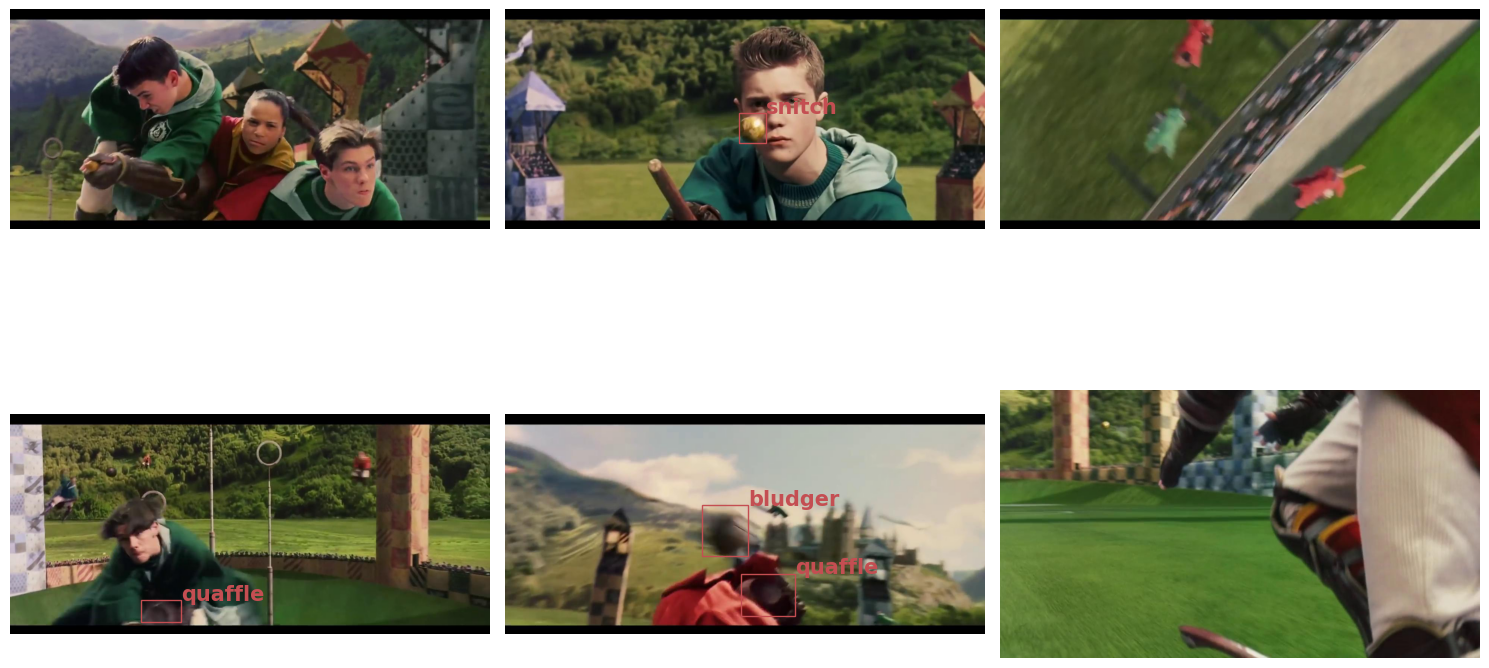

In [ ]:
import tensorflow as tf
import matplotlib.patches as patches

cnt = 6
fig, axes = plt.subplots(
        2, cnt // 2 + cnt % 2, figsize=(15, 10), dpi=100
    )

for i, ax in enumerate(axes.reshape(-1)):
  ax.axis(False)
  channels = tf.unstack(res[i].orig_img, axis=-1) #https://stackoverflow.com/questions/42161916/tensorflow-how-to-switch-channels-of-a-tensor-from-rgb-to-bgr
  image = tf.stack([channels[2], channels[1], channels[0]], axis=-1)
  ax.imshow(image)
  if len(res[i].boxes.cls) == 0:
    continue
  for y in range(len(res[i].boxes.cls)):
    bbox = res[i].boxes.xyxy[y].cpu()
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    lab = res[i].boxes.cls[y].cpu().numpy()
    ax.text(bbox[2], bbox[1], train_ds.class_dict_inv[lab.item()], fontweight='bold', color='r', size=15)
    ax.add_patch(rect)

fig.tight_layout()
plt.show()